# imports & catalogues

In [36]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy.table import join
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import astropy.cosmology.units as cu
from astropy.coordinates import SkyCoord
from scipy.optimize import linear_sum_assignment
import Code.all_fctns as all_fctns
import os
import scipy as sp
import plot_tools

from dr_tools.sami_fluxcal import sami_read_apspec

SAMI_Target_catalogues = ("InputCatGAMADR3.fits", "InputCatClustersDR3.fits", "InputCatFiller.fits")
SAMI_regions = {0: "GAMA", 1: "Clusters", 2: "Filler"}

Source_dir ="C:\\Users\\mspan\\OneDrive - The University of Sydney (Students)\\Honours\\Honours Project\\"
catalogue_filepath = Source_dir + "Catalogues\\"
SAMI_regions = ("Cluster", "Filler", "GAMA")
SAMI_spectra_catalogue = "EmissionLine1compDR3.fits"
SAMI_SFR_catalogue = "AR2022_SAMI_DR3_Mstar_SFR_GSWL_rescaled.fits"
SAMI_AGN_summary_catalogue = "Crossmatched\\SAMI_AGN_matches.fits"
SAMI_cubeobs_catalogue = "CubeObs.fits"

shared_catalogue_filepath = Source_dir +  "SAMI_TOOLS_SMC_MSPA4681\\shared_catalogues\\"
gassig_statistics_catalogue = "gassig_statistics.fits"

def refresh_module():
    import importlib
    import Code.all_fctns as all_fctns
    import EW_Ha_tools
    importlib.reload(EW_Ha_tools)
    importlib.reload(all_fctns)
    importlib.reload(plot_tools)

ifs_path = Source_dir + "sami_tools_smc_mspa4681\\some_sample_ifs\\"

CATIDs = 40916, 9011900711, 298590, 6821

# plotting spectra

[6427.819 6492.819] [6632.819 6697.819]
Region 1 flux: 0.20 +/- 0.01


c:\Users\mspan\OneDrive - The University of Sydney (Students)\Honours\Honours Project\sami_tools_smc_mspa4681\plot_tools.py:433: SyntaxWarning: invalid escape sequence '\A'
  


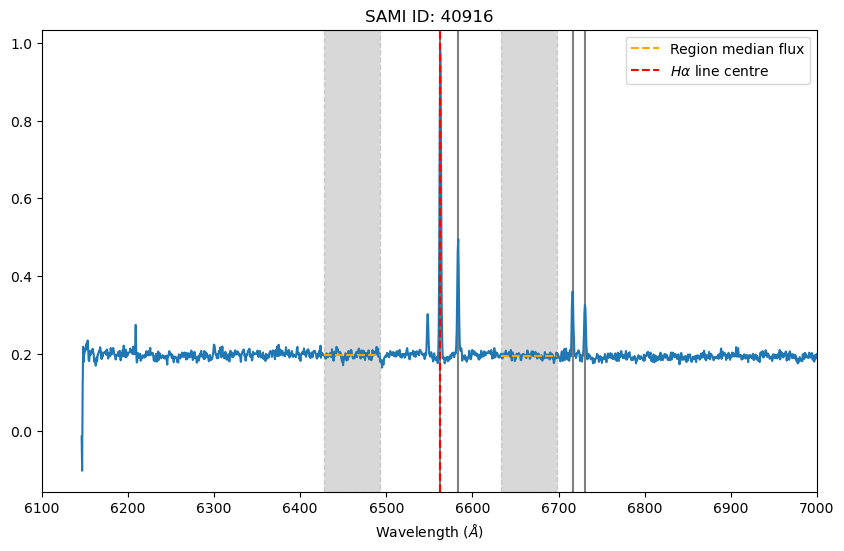

In [37]:
refresh_module()
CATIDs = 40916, 9011900711, 298590, 6821
CATID = CATIDs[0]

fig, ax = plt.subplots(1,1, figsize=(10,6))

def get_redshift_corrected_spectra(CATID, ifs_path=ifs_path):
    apspecfile_red = os.path.join(ifs_path,str(CATID), str(CATID)+'_A_spectrum_1-4-arcsec_red.fits')
    hdulist = fits.open(apspecfile_red)
    sami_flux_red,sami_lam_red = sami_read_apspec(hdulist,0,doareacorr=False)
    hdulist.close()
    redshift = all_fctns.get_z_best(catalogue_filepath, [CATID], only_spec=True)
    sami_lam_red_zcorr = sami_lam_red / (1 + redshift)
    return sami_flux_red, sami_lam_red_zcorr

sami_flux_red, sami_lam_red_zcorr = get_redshift_corrected_spectra(CATID)
ax.plot(sami_lam_red_zcorr, sami_flux_red)
plot_tools.plot_line_lam(ax, z=0, annotations=False)
ax.set_title(f"SAMI ID: {CATID}")
ax.set_xlabel(r"Wavelength ($\AA$)")
ax.set_xlim(6100,7000)


# set regions for collecting continuum flux symmetric about 6562
region_width = 65
region_separation = 140
Ha_lam = 6562.819
region1 = np.array([-region_width, 0]) + Ha_lam - region_separation/2  
region2 = np.array([0, region_width]) + Ha_lam + region_separation/2  
print(region1, region2)

# plot these regions
ax.axvspan(region1[0], region1[1], color='grey', alpha=0.3, linestyle='--')
ax.axvspan(region2[0], region2[1], color='grey', alpha=0.3, linestyle='--')




def get_spectra_region_flux(sami_lam, sami_flux, region, estimation_method='median'):
    """Get the mean flux in a given wavelength region."""
    region_mask = (sami_lam >= region[0]) & (sami_lam <= region[1])
    region_flux = np.mean(sami_flux[region_mask])
    region_flux_err = np.std(sami_flux[region_mask]) # check this
    return region_flux, region_flux_err

region1_flux, region1_flux_err = get_spectra_region_flux(sami_lam_red_zcorr, sami_flux_red, region1)
region2_flux, region2_flux_err = get_spectra_region_flux(sami_lam_red_zcorr, sami_flux_red, region2)
print(f"Region 1 flux: {region1_flux:.2f} +/- {region1_flux_err:.2f}")

ax.plot(region1, [region1_flux]*2, color='orange', linestyle='--', label='Region median flux')
ax.plot(region2, [region2_flux]*2, color='orange', linestyle='--')

ax.axvline(Ha_lam, color='red', linestyle='--', label='$H\\alpha$ line centre')
ax.legend()


[6427.819 6492.819] [6632.819 6697.819]
Region 1 flux: 0.20 +/- 0.01


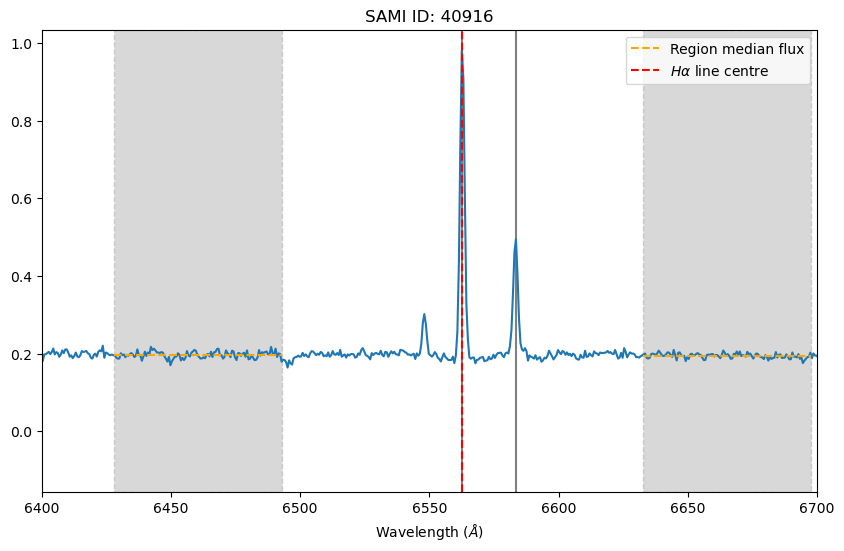

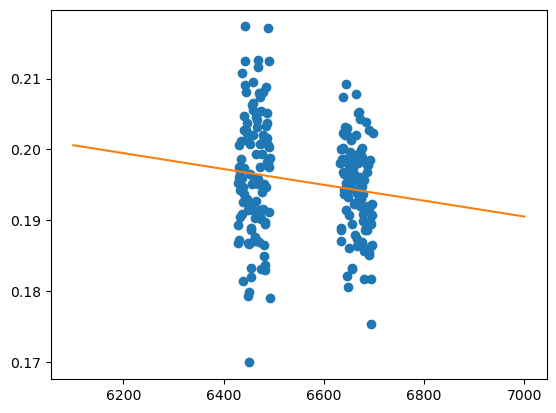

In [38]:
refresh_module()
CATID = CATIDs[0]

fig, ax = plt.subplots(1,1, figsize=(10,6))

sami_flux_red, sami_lam_red_zcorr = get_redshift_corrected_spectra(CATID)
ax.plot(sami_lam_red_zcorr, sami_flux_red)
plot_tools.plot_line_lam(ax, z=0, annotations=False)
ax.set_title(f"SAMI ID: {CATID}")
ax.set_xlabel(r"Wavelength ($\AA$)")
ax.set_xlim(6100,7000)


# set regions for collecting continuum flux symmetric about 6562
region_width = 65
region_separation = 140
Ha_lam = 6562.819
region1 = np.array([-region_width, 0]) + Ha_lam - region_separation/2  
region2 = np.array([0, region_width]) + Ha_lam + region_separation/2  
print(region1, region2)

# plot these regions
ax.axvspan(region1[0], region1[1], color='grey', alpha=0.3, linestyle='--')
ax.axvspan(region2[0], region2[1], color='grey', alpha=0.3, linestyle='--')


def get_spectra_region_flux(sami_lam, sami_flux, region, estimation_method='median'):
    """Get the mean flux in a given wavelength region."""
    region_mask = (sami_lam >= region[0]) & (sami_lam <= region[1])
    region_flux = np.mean(sami_flux[region_mask])
    region_flux_err = np.std(sami_flux[region_mask]) # check this
    return region_flux, region_flux_err

region1_flux, region1_flux_err = get_spectra_region_flux(sami_lam_red_zcorr, sami_flux_red, region1)
region2_flux, region2_flux_err = get_spectra_region_flux(sami_lam_red_zcorr, sami_flux_red, region2)
print(f"Region 1 flux: {region1_flux:.2f} +/- {region1_flux_err:.2f}")

ax.plot(region1, [region1_flux]*2, color='orange', linestyle='--', label='Region median flux')
ax.plot(region2, [region2_flux]*2, color='orange', linestyle='--')

ax.axvline(Ha_lam, color='red', linestyle='--', label='$H\\alpha$ line centre')
ax.legend()

ax.set_xlim(6400, 6700)

plt.show()

plt.figure()

region_width = 65
region_separation = 140
Ha_lam = 6562.819
region1 = np.array([-region_width, 0]) + Ha_lam - region_separation/2  
region2 = np.array([0, region_width]) + Ha_lam + region_separation/2  
regions = (region1, region2)

# get the relevant points for line fitting
regions_mask = (sami_lam_red_zcorr >= regions[0][0]) & (sami_lam_red_zcorr <= regions[0][1]) | (sami_lam_red_zcorr >= regions[1][0]) & (sami_lam_red_zcorr <= regions[1][1])
regions_sami_lam_red_zcorr = sami_lam_red_zcorr[regions_mask]
regions_sami_flux_red = sami_flux_red[regions_mask]

plt.plot(regions_sami_lam_red_zcorr, regions_sami_flux_red, 'o')

# fit a line to these points
res = sp.stats.linregress(regions_sami_lam_red_zcorr, regions_sami_flux_red)
slope, intercept, slope_err, intercept_err = res.slope, res.intercept, res.stderr, res.intercept_stderr
continuum_flux = slope*Ha_lam + intercept
continuum_flux_err = np.sqrt( (slope_err*Ha_lam)**2 + intercept_err**2 )
lambda_fit = np.linspace(6100, 7000, 1000)
plt.plot(lambda_fit, slope*lambda_fit + intercept, label='Linear fit to continuum regions')

In [48]:
refresh_module()
print(ifs_path)
EW_Ha_tools.get_Halpha_EW_table(CATIDs, ifs_path=ifs_path, catalogue_filepath=catalogue_filepath)


C:\Users\mspan\OneDrive - The University of Sydney (Students)\Honours\Honours Project\sami_tools_smc_mspa4681\some_sample_ifs\


CATID,HAlpha_EW_MedianFit,HAlpha_EW_err_MedianFit,HAlpha_EW_LineFit,HAlpha_EW_err_LineFit
int64,float64,float64,float64,float64
40916,10.152496587502498,0.5751340684389937,10.160142567085396,2.3999914642170133
9011900711,0.01634351412744184,0.03656297964581625,0.016297731129559904,0.03652766705403445
298590,8.358235187814408,0.2831222157971041,8.368069404276577,1.1441057578990552
6821,753.8102210052308,389.5251689243251,716.1965058647987,1478.4184035514984


In [49]:
with fits.open(catalogue_filepath + SAMI_spectra_catalogue) as SAMI_spectra_hdul:
    SAMI_spectra_table_hdu = Table(SAMI_spectra_hdul[1].data)

CATID = 15165
SAMI_spectra_table_hdu[SAMI_spectra_table_hdu['CATID'] == CATID]['HALPHA_1_4_ARCSECOND']

1.5370374
0.9380064


# WHaN plot

['CATID', 'HAlpha_EW_MedianFit', 'HAlpha_EW_err_MedianFit', 'HAlpha_EW_LineFit', 'HAlpha_EW_err_LineFit']


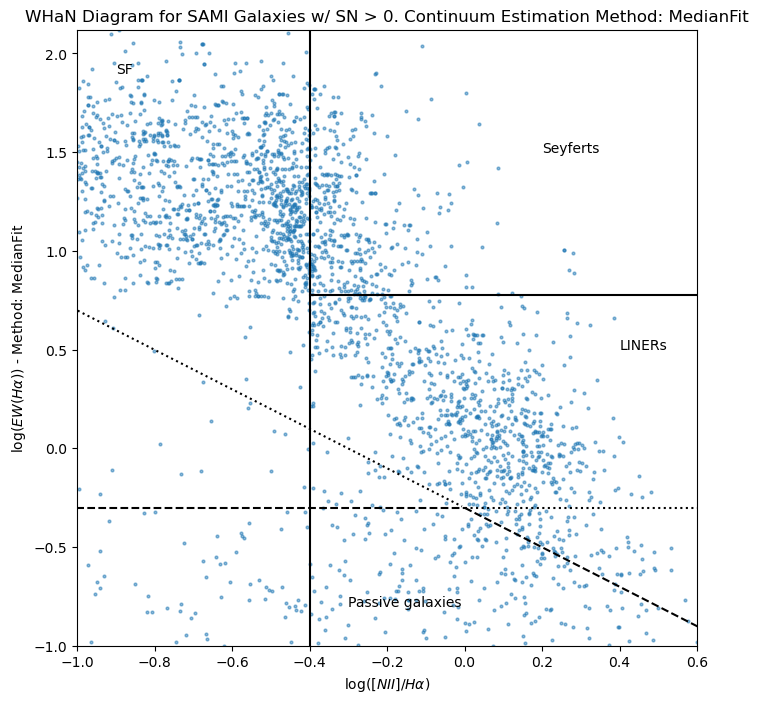

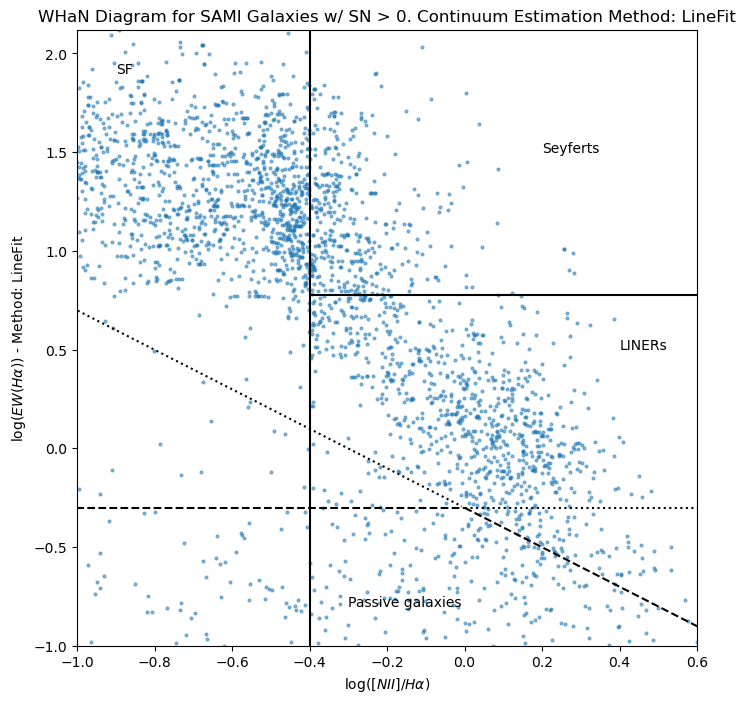

In [ ]:
def plot_WHAN_lines(ax, paper='Cid Fernandes et al. (2011)', region_labels=True, fontsize=15):
    xrange = ax.get_xlim()
    yrange = ax.get_ylim()

    xs = np.linspace(xrange[0], xrange[1], 1000)

    if paper == 'Cid Fernandes et al. (2011)':
        m_line = (np.log10(5)-np.log10(0.5))/(-1-0)
        c_line = np.log10(0.5)

        # uncertain lines
        ax.plot(xs[xs<0], m_line*xs[xs<0] + c_line, 'k:')
        ax.plot([0, xrange[1]], [np.log10(0.5)]*2, 'k:')

        # passive galaxy lines
        ax.plot(xs[xs>0], m_line*xs[xs>0] + c_line, 'k--')
        ax.plot([xrange[0], 0], [np.log10(0.5)]*2, 'k--')

        ax.plot([-0.4, xrange[1]], [np.log10(6)]*2, color='k') # K06 Seyfert/LINER line
        ax.axvline(-0.4, color='k') # S06 SF/AGN line

        if region_labels:
            ax.text(0.2, 1.5, 'Seyferts', size=fontsize)
            ax.text(0.4, 0.5, 'LINERs', size=fontsize)
            ax.text(-0.9, 1.9, 'SF', size=fontsize)
            ax.text(-0.3, -0.8, 'Passive galaxies', size=fontsize)


estimation_methods = ('MedianFit', 'LineFit')


with fits.open(shared_catalogue_filepath + "HAlpha_EW_Table.fits") as Ha_EW_hdul:
    Ha_EW_table = Table(Ha_EW_hdul[1].data)

print(Ha_EW_table.colnames)

with fits.open( os.path.join(catalogue_filepath, SAMI_spectra_catalogue) ) as SAMI_spectra_hdul:
    SAMI_spectra_table_hdu = Table(SAMI_spectra_hdul[1].data)


reduced_spectra_table = SAMI_spectra_table_hdu.copy()
reduced_spectra_table.keep_columns(['CATID', 'NII6583_1_4_ARCSECOND', 'NII6583_1_4_ARCSECOND_ERR', 'HALPHA_1_4_ARCSECOND', 'HALPHA_1_4_ARCSECOND_ERR'])

HA_EW_NII_HA_table = join(Ha_EW_table, reduced_spectra_table, keys='CATID', join_type='inner')

SN_lim=0
method = 'LineFit'


for method in estimation_methods:
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    SN_mask = (HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND'] / HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND_ERR'] > SN_lim) & (HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND'] / HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND_ERR'] > SN_lim) & (HA_EW_NII_HA_table[f'HAlpha_EW_{method}'] / HA_EW_NII_HA_table[f'HAlpha_EW_err_{method}'] > SN_lim)

    ax.plot(np.log10(HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND'][SN_mask] / HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND'][SN_mask]), np.log10(HA_EW_NII_HA_table[f'HAlpha_EW_{method}'][SN_mask]), 'o', markersize=2, alpha=0.5)

    ax.set_xlabel(r"$\log([NII]/H\alpha)$")
    ax.set_ylabel(r"$\log(EW(H\alpha))$" + f" - Method: {method}")

    ax.set_title(f"WHaN Diagram for SAMI Galaxies w/ SN > {SN_lim}. Continuum Estimation Method: {method}")

    plot_WHAN_lines(ax, fontsize=10)
    ax.set_xlim(-1, 0.6)
    ax.set_ylim(-1, 2.12)



## WHAN w/ BPT labels

In [68]:
BPT_values = (0,1,2,3,4,5,6,7,8,9,10,-1)
BPT_labels = ('HII', 'HII/Comp', 'Comp', 'AGN/Comp', 'HII/Comp/AGN', 'HII/AGN', 'LINER', 'Seyfert', 'Boundary AGN', 'AGN OIII', 'AGN - NII limit only', 'Inconclusive')
BPT_colors = ('red', 'orange', 'yellow', 'purple',      'magenta',     'pink',  'green', 'blue',    'cyan',         'blue',     'green',    'black')
BPT_marker = ('o',      'o',    'o',        'o',        'o',            'o',    'o',        'o',    'o',            's',        's',        'x')

full_BPT_classification_dict = {i: (label, color, marker) for i, label, color, marker in zip(BPT_values, BPT_labels, BPT_colors, BPT_marker)}

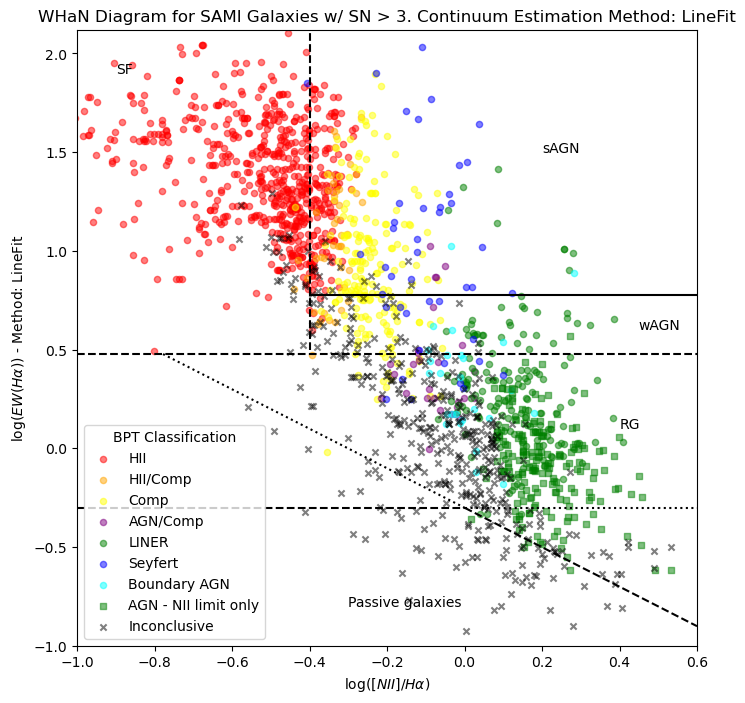

In [99]:
with fits.open(shared_catalogue_filepath + "HAlpha_EW_Table.fits") as Ha_EW_hdul:
    Ha_EW_table = Table(Ha_EW_hdul[1].data)

with fits.open( os.path.join(catalogue_filepath, SAMI_spectra_catalogue) ) as SAMI_spectra_hdul:
    SAMI_spectra_table_hdu = Table(SAMI_spectra_hdul[1].data)

with fits.open( os.path.join(shared_catalogue_filepath, "SAMI_AGN_matches.fits") ) as SAMI_AGN_matches_hdul:
    Summary_table_hdu = Table(SAMI_AGN_matches_hdul[1].data)


reduced_spectra_table = SAMI_spectra_table_hdu.copy()
reduced_spectra_table.keep_columns(['CATID', 'NII6583_1_4_ARCSECOND', 'NII6583_1_4_ARCSECOND_ERR', 'HALPHA_1_4_ARCSECOND', 'HALPHA_1_4_ARCSECOND_ERR'])
HA_EW_NII_HA_table = join(Ha_EW_table, reduced_spectra_table, keys='CATID', join_type='inner')
HA_EW_NII_HA_table = join(HA_EW_NII_HA_table, Summary_table_hdu['CATID', 'CATEGORY_BPT_AGN'], keys='CATID', join_type='left')

SN_lim=3
method = 'LineFit'

fig, ax = plt.subplots(1,1, figsize=(8,8))
SN_mask = ((HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND'] / HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND_ERR'] > SN_lim) 
           & (HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND'] / HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND_ERR'] > SN_lim) 
           & (HA_EW_NII_HA_table[f'HAlpha_EW_{method}'] / HA_EW_NII_HA_table[f'HAlpha_EW_err_{method}'] > SN_lim) )

for bpt_value, (bpt_label, bpt_color, bpt_marker) in full_BPT_classification_dict.items():
    bpt_mask = (HA_EW_NII_HA_table['CATEGORY_BPT_AGN'] == bpt_value) & SN_mask
    if np.sum(bpt_mask) > 0:
        ax.scatter(np.log10(HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND'][bpt_mask] / HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND'][bpt_mask]), 
                   np.log10(HA_EW_NII_HA_table[f'HAlpha_EW_{method}'][bpt_mask]), 
                   c=bpt_color, marker=bpt_marker, s=20, alpha=0.5, label=bpt_label)

# ax.plot(np.log10(HA_EW_NII_HA_table['NII6583_1_4_ARCSECOND'][SN_mask] / HA_EW_NII_HA_table['HALPHA_1_4_ARCSECOND'][SN_mask]), 
#         np.log10(HA_EW_NII_HA_table[f'HAlpha_EW_{method}'][SN_mask]), markersize=2, alpha=0.5)

ax.set_xlabel(r"$\log([NII]/H\alpha)$")
ax.set_ylabel(r"$\log(EW(H\alpha))$" + f" - Method: {method}")

ax.set_title(f"WHaN Diagram for SAMI Galaxies w/ SN > {SN_lim}. Continuum Estimation Method: {method}")

ax.set_xlim(-1, 0.6)
ax.set_ylim(-1, 2.12)
refresh_module()
EW_Ha_tools.plot_WHAN_lines(ax, fontsize=10, paper='Fernandes (2011) - strong/weak')

ax.legend(title='BPT Classification', loc='lower left')

plt.show()


# EW(Ha) for Cubes

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                   50                                                  NAXIS2  =                   50                                                  NAXIS3  =                 2048                                                  EXTEND  =                    T                                                  WCSAXES =                    3 / Number of coordinate axes                      CRPIX1  =                 25.5 / Pixel coordinate of reference point            CRPIX2  =                 25.5 / Pixel coordinate of reference point            CRPIX3  =               1024.0 / Pixel coordinate of reference point            CDELT1  = -0.00013888888888889 / [deg] Coordinate increment at reference point  CDELT2  =  0.00013888888888889 / [deg] C

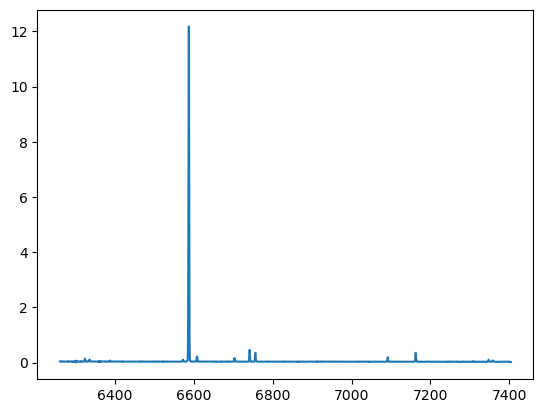

In [ ]:
refresh_module()
import EW_Ha_tools

test_CATID= CATIDs[3]



lam, flux, variance = EW_Ha_tools.read_cube(os.path.join(ifs_path, str(test_CATID), f"{test_CATID}_A_cube_red.fits.gz")
          )
# test_cube = fits.open(os.path.join(ifs_path, str(test_CATID), f"{test_CATID}_A_cube_red.fits.gz"))
# test_cube.info()

# cube_data = test_cube[0].data
# print(np.sum(np.isnan(cube_data[0])))

# plt.imshow(np.nansum(flux, axis=0), origin='lower')

plt.plot(lam, flux[:,24,24])



SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                   50                                                  NAXIS2  =                   50                                                  NAXIS3  =                 2048                                                  EXTEND  =                    T                                                  WCSAXES =                    3 / Number of coordinate axes                      CRPIX1  =                 25.5 / Pixel coordinate of reference point            CRPIX2  =                 25.5 / Pixel coordinate of reference point            CRPIX3  =               1024.0 / Pixel coordinate of reference point            CDELT1  = -0.00013888888888889 / [deg] Coordinate increment at reference point  CDELT2  =  0.00013888888888889 / [deg] C

C:\Users\mspan\AppData\Local\Temp\ipykernel_27928\3373308924.py:117: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


<Axes: xlabel='log([NII]/Ha)', ylabel='log(EW(Ha))'>

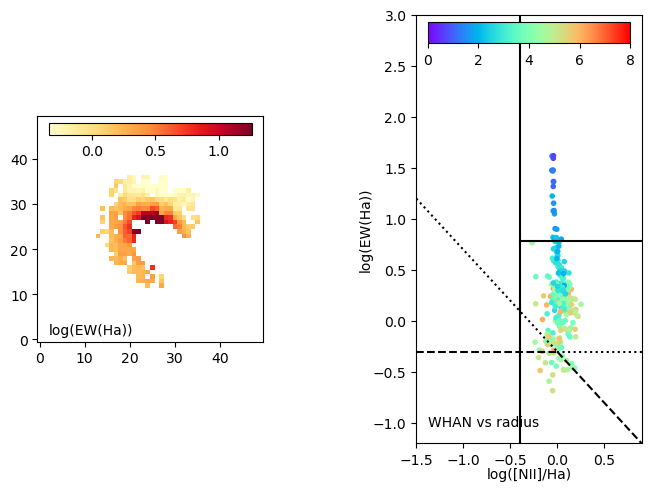

In [ ]:
refresh_module()

def get_Halpha_EW_image(catid, ifs_path=ifs_path, estimation_method='median', haflux_masked=None, haerr=None, ha_SN_lim=3, redshift_spec=None, bin='default'):
    """Get the Halpha EW at each spaxel in the cube.
    Can take in a pre-masked Halpha flux array to avoid re-calculating the mask.
    Can take in a specific estimation method (e.g., 'median', 'mean') for the EW calculation.

    Returns Ha_EW_image, Ha_EW_err_image
    """

    # first read in the cube - check that this is alwats catid_A
    lam, flux, variance = EW_Ha_tools.read_cube(os.path.join(ifs_path, str(catid), f"{catid}_A_cube_red.fits.gz"))

    # redshift correct the wavelength array
    if redshift_spec is None:
        redshift_spec = all_fctns.get_z_best(catalogue_filepath, [catid], only_spec=True)
    
    lam = lam / (1 + redshift_spec)
    


    if haflux_masked is None:
        # copied from scotts original dr3_sov code:
        haflux_file = os.path.join(ifs_path, str(catid),str(catid)+'_A_Halpha_'+bin+'_1-comp.fits')
        haflux = fits.getdata(haflux_file, ext=0)[0,:,:]
        haerr =  fits.getdata(haflux_file, extname='HALPHA_ERR')[0,:,:]
        hasn = haflux/haerr
        ha_snflag = np.where((hasn > ha_SN_lim),0,1)
        haflux_masked = np.ma.masked_array(haflux,(ha_snflag>0))

    HAlpha_EW_image = np.zeros(haflux_masked.shape)
    HAlpha_EW_err_image = np.zeros(haflux_masked.shape)
    counter = 0

    # now iterate over each spaxel
    for i in range(haflux_masked.shape[0]):
        for j in range(haflux_masked.shape[1]):
            # if not (i in (16,17,18,19,20,21) and (j in (16,17,18,19,20,21))):
                # continue

            if not haflux_masked.mask[i,j]:
                # print(np.sum(~np.isnan(flux[:,i,j])))
                HAlpha_EW_image[i,j], HAlpha_EW_err_image[i,j] = EW_Ha_tools.get_Halpha_EW(catid, ifs_path=ifs_path, estimation_method=estimation_method, 
                                                                                sami_flux_red=flux[:,i,j], sami_lam_red=lam, already_zcorr=True,
                                                                                HAlpha_flux=haflux_masked[i,j], HAlpha_error=haerr[i,j])
            else:
                HAlpha_EW_image[i,j] = np.nan
                HAlpha_EW_err_image[i,j] = np.nan
            
            # print(f"Spaxel ({i},{j}): EW = {HAlpha_EW_image[i,j]}, EW_err = {HAlpha_EW_err_image[i,j]}")
            # EW_Ha_tools.get_Halpha_EW_spectra_investigation_plot(flux[:,i,j], lam, haflux_masked[i,j], haerr[i,j])

            if HAlpha_EW_image[i,j] > 0:
                counter += 1
                
    # print(f"Counter: {counter}")

    # print(np.sum(HAlpha_EW_image>0))

    return HAlpha_EW_image, HAlpha_EW_err_image


bin='default'


# plt.imshow(HAlpha_EW_image, origin='lower', vmin=0, vmax=50)

import pylab as py
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

snlim= 3

catid= CATIDs[2]

haflux_file = os.path.join(ifs_path, str(catid),str(catid)+'_A_Halpha_'+bin+'_1-comp.fits')
haflux = fits.getdata(haflux_file, ext=0)[0,:,:]
haerr =  fits.getdata(haflux_file, extname='HALPHA_ERR')[0,:,:]
hasn = haflux/haerr
ha_snflag = np.where((hasn > snlim),0,1)
haflux_masked = np.ma.masked_array(haflux,(ha_snflag>0))

n2flux_file = os.path.join(ifs_path, str(catid),str(catid)+'_A_NII6583_'+bin+'_1-comp.fits')
n2flux = fits.getdata(n2flux_file, ext=0)
n2err =  fits.getdata(n2flux_file, extname='NII6583_ERR')
n2sn = n2flux/n2err
n2ha = np.log10(n2flux/haflux)
n2ha_snflag = np.where(((hasn > snlim) & (n2sn > snlim)),0,1)
n2ha_masked = np.ma.masked_array(n2ha,(n2ha_snflag>0))


fig1 = py.figure(1,constrained_layout=True)
fig1.clf()
gs = fig1.add_gridspec(1, 2,wspace=0.3,hspace=0.3,top=0.95,bottom=0.1)



ax_ha_ew = fig1.add_subplot(gs[0,0]) # change this
ax_ha_ew.set_aspect('equal', 'box')

ha_ew, ha_ew_err= get_Halpha_EW_image(test_CATID, estimation_method='median', bin=bin, haflux_masked=haflux_masked, haerr=haerr) # haflux_masked=haflux_masked, haerr=haerr, redshift=redshift

ha_ewsn = ha_ew / ha_ew_err
ha_ew_snflag = np.where((ha_ewsn > snlim),0,1)
ha_ew_masked = np.ma.masked_array(ha_ew,(ha_ew_snflag>0))

vmin = np.log10( np.nanpercentile(ha_ew,5.0) )
vmax = np.log10(np.nanpercentile(ha_ew,95.0))



print(vmin, vmax)

im_ha_ew = ax_ha_ew.imshow(np.log10(ha_ew_masked),origin='lower',interpolation='nearest',cmap=py.cm.YlOrRd,vmin=vmin,vmax=vmax)
axins_ha_ew = inset_axes(ax_ha_ew,width="90%",height="5%",loc='upper center')
fig1.colorbar(im_ha_ew, cax=axins_ha_ew, orientation="horizontal")
ax_ha_ew.text(0.05, 0.05,'log(EW(Ha))', horizontalalignment='left',verticalalignment='center', transform=ax_ha_ew.transAxes)
fig1.show()



# plot WHaN diagram
snflag = np.where(((hasn > snlim) & (n2sn > snlim) & (ha_ewsn > snlim)),0,1)
            
ha_ew_masked = np.ma.masked_array(ha_ew,(snflag>0))
n2ha_masked = np.ma.masked_array(n2ha,(snflag>0))

# set up grid to get distance from centre (in arcsec):
x = y = np.arange(0.0,50.0,1.0)
X, Y = np.meshgrid(x, y)
xcent = 25.0
ycent = 25.0
rdist = np.sqrt((X-xcent)**2 + (Y-ycent)**2)/2.0

# ax_whan = fig1.add_subplot(gs[3,3])
ax_whan = fig1.add_subplot(gs[0,1])
im_whan = ax_whan.scatter(n2ha_masked,np.log10(ha_ew_masked),c=rdist,marker='.',vmin=0.0,vmax=8.0,cmap=py.cm.rainbow)
ax_whan.text(0.05, 0.05,'WHAN vs radius', horizontalalignment='left',verticalalignment='center', transform=ax_whan.transAxes)
ax_whan.xaxis.labelpad=0
ax_whan.yaxis.labelpad=0



axins_whan = inset_axes(ax_whan,width="90%",height="5%",loc='upper center')
fig1.colorbar(im_whan, cax=axins_whan, orientation="horizontal")

ax_whan.set(xlim=[-1.5,0.9],ylim=[-1.2,3],xlabel='log([NII]/Ha)',ylabel='log(EW(Ha))')
# plot WHAN lines:
EW_Ha_tools.plot_WHAN_lines(ax_whan, fontsize=10, region_labels=False)


[6427.819 6492.819] [6632.819 6697.819]


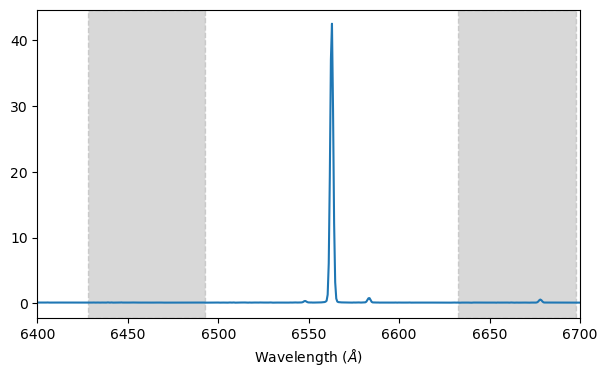

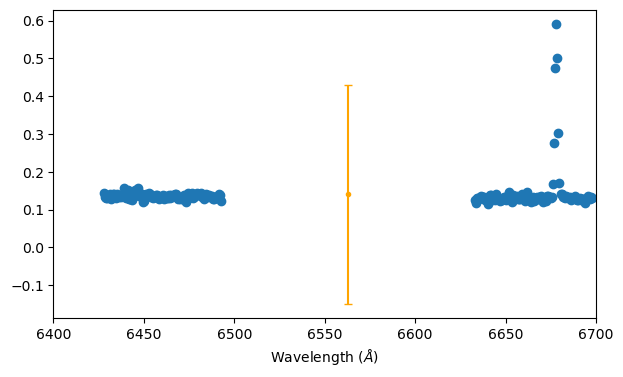

In [ ]:
refresh_module()

sami_flux_red, sami_lam_red_zcorr = get_redshift_corrected_spectra(test_CATID)
HAlpha_flux, HAlpha_error = all_fctns.get_flux_and_error_1_4_ARCSEC(SAMI_spectra_table_hdu[SAMI_spectra_table_hdu['CATID'] == test_CATID], 'H Alpha')

EW_Ha_tools.get_Halpha_EW_spectra_investigation_plot(sami_flux_red, sami_lam_red_zcorr, HAlpha_flux, HAlpha_error)
